<a href="https://colab.research.google.com/github/2303a52239/Explainable-AI-/blob/main/ml_models_of_XAI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


🚀 Training and Evaluating Models...

📊 Model Performance Comparison:

              Model  Accuracy  Precision   Recall  F1-Score  ROC-AUC
      Random Forest  0.708437   0.332302 0.239392  0.252886 0.822598
      Decision Tree  0.703944   0.290000 0.236710  0.244045 0.821620
                KNN  0.649526   0.232694 0.227151  0.221870 0.676816
  Gradient Boosting  0.700949   0.324781 0.211780  0.208947 0.793535
Logistic Regression  0.696955   0.395874 0.209384  0.208598 0.771966
           AdaBoost  0.686470   0.208637 0.195553  0.193577 0.738550
                SVM  0.701947   0.209257 0.197462  0.187585 0.725043
        Naive Bayes  0.041937   0.197032 0.246829  0.051023 0.656536

🏆 Best Model based on F1-Score: Random Forest

🧩 Confusion Matrix for Best Model:

   0  1   2  3   4     5  6
0  8  1  21  0   9    26  0
1  0  3  24  0  11    65  0
2  9  2  86  0  19   101  3
3  0  0   0  0   1    22  0
4  6  7  29  0  25   156  0
5  5  3  25  0  19  1289  0
6  0  0   3  0   0    25  0


/tmp/ipython-input-655380762.py:128: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


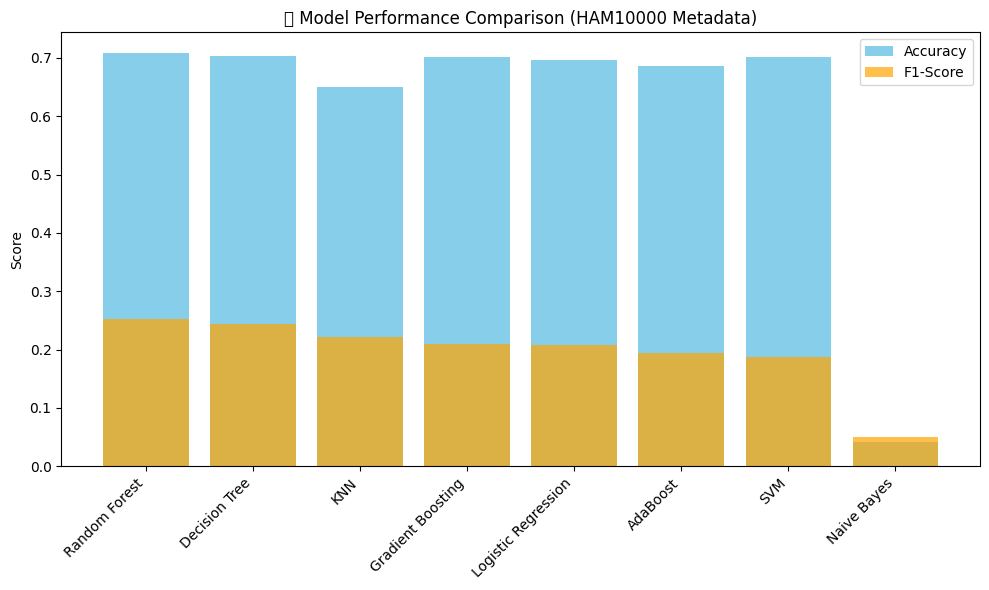

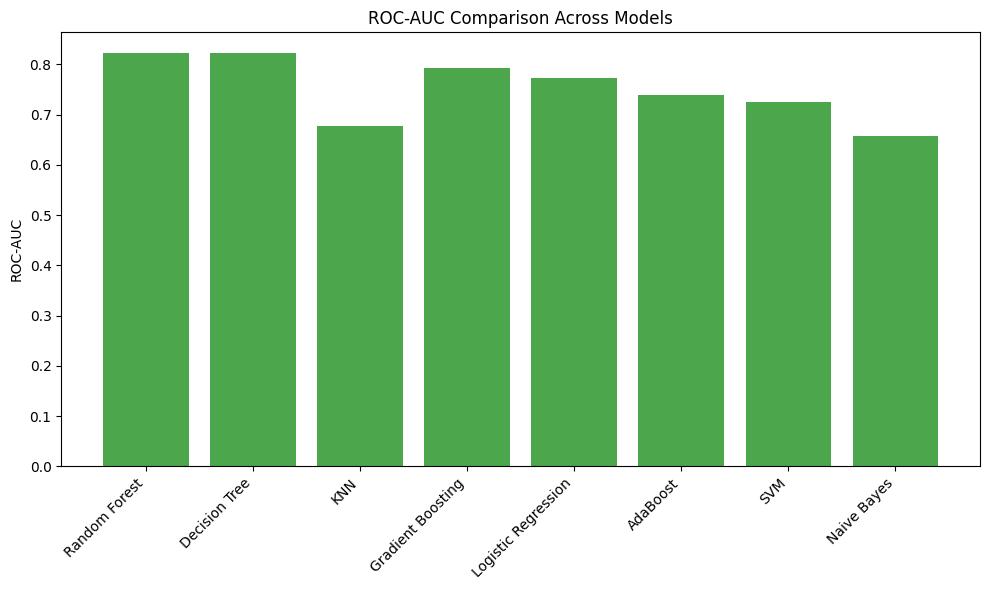

In [5]:
# 📊 Apply all ML models on HAM10000 metadata + show visual comparison
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# ML Models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

# 1️⃣ Load dataset
df = pd.read_csv("/content/HAM10000_metadata.csv")

# 2️⃣ Select features & target
features = ["age", "sex", "localization"]
target = "dx"
df = df[features + [target]].dropna(subset=[target])

# 3️⃣ Handle missing values
num_features = ["age"]
cat_features = ["sex", "localization"]

num_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

cat_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore", sparse_output=False))  # ✅ sklearn >=1.2
])

preprocessor = ColumnTransformer([
    ("num", num_transformer, num_features),
    ("cat", cat_transformer, cat_features)
])

# 4️⃣ Encode target
le = LabelEncoder()
df[target] = le.fit_transform(df[target])

X = df[features]
y = df[target]

# 5️⃣ Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# 6️⃣ Define ML models
models = {
    "Logistic Regression": LogisticRegression(max_iter=500),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "AdaBoost": AdaBoostClassifier(),
    "KNN": KNeighborsClassifier(),
    "SVM": SVC(probability=True),
    "Naive Bayes": GaussianNB()
}

# 7️⃣ Train & evaluate all models
results = []

print("\n🚀 Training and Evaluating Models...\n")

for name, model in models.items():
    pipeline = Pipeline([("preprocessor", preprocessor), ("model", model)])
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average="macro", zero_division=0)
    rec = recall_score(y_test, y_pred, average="macro", zero_division=0)
    f1 = f1_score(y_test, y_pred, average="macro", zero_division=0)

    # ROC-AUC (if available)
    try:
        y_proba = pipeline.predict_proba(X_test)
        auc = roc_auc_score(y_test, y_proba, multi_class="ovr", average="macro")
    except:
        auc = None

    results.append([name, acc, prec, rec, f1, auc])

# 8️⃣ Display results
results_df = pd.DataFrame(results, columns=["Model", "Accuracy", "Precision", "Recall", "F1-Score", "ROC-AUC"])
results_df = results_df.sort_values(by="F1-Score", ascending=False).reset_index(drop=True)

print("📊 Model Performance Comparison:\n")
print(results_df.to_string(index=False))

# 9️⃣ Best model
best_model = results_df.loc[0, "Model"]
print(f"\n🏆 Best Model based on F1-Score: {best_model}")

# 🔟 Confusion Matrix for Best Model
best_pipeline = Pipeline([("preprocessor", preprocessor), ("model", models[best_model])])
best_pipeline.fit(X_train, y_train)
y_pred_best = best_pipeline.predict(X_test)
cm = confusion_matrix(y_test, y_pred_best)

print("\n🧩 Confusion Matrix for Best Model:\n")
print(pd.DataFrame(cm))

# 11️⃣ Save CSV files
results_df.to_csv("ml_results.csv", index=False)
pd.DataFrame(cm).to_csv("confusion_matrix_best_model.csv", index=False)
print("\n💾 Results saved as 'ml_results.csv' and 'confusion_matrix_best_model.csv'")

# 12️⃣ Visualize Performance
plt.figure(figsize=(10, 6))
plt.bar(results_df["Model"], results_df["Accuracy"], color="skyblue", label="Accuracy")
plt.bar(results_df["Model"], results_df["F1-Score"], color="orange", alpha=0.7, label="F1-Score")
plt.xticks(rotation=45, ha='right')
plt.title("📈 Model Performance Comparison (HAM10000 Metadata)")
plt.ylabel("Score")
plt.legend()
plt.tight_layout()
plt.show()

# ROC-AUC plot if available
if results_df["ROC-AUC"].notnull().any():
    plt.figure(figsize=(10, 6))
    plt.bar(results_df["Model"], results_df["ROC-AUC"], color="green", alpha=0.7)
    plt.xticks(rotation=45, ha='right')
    plt.title("ROC-AUC Comparison Across Models")
    plt.ylabel("ROC-AUC")
    plt.tight_layout()
    plt.show()
